In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sentiment tools
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import nltk

In [ ]:
# import file and convert into dataframe
file_path = 'feedback.xlsx'  
df = pd.read_excel(file_path)

# Show first rows
display(df.head(5))

# Quick check for missing values in the Feedback column
if 'Feedback' in df.columns:
    print("\nMissing values in 'Feedback':", df['Feedback'].isna().sum())
else:
    raise KeyError("No column named 'Feedback' found. Please check your Excel file.")


In [ ]:
# show dataframe shape
df.shape

In [ ]:
# Create a cleaned version of the Feedback column for processing - remove extra spaces and tabs
df['feedback_raw'] = df['Feedback'].astype(str)
df['feedback_clean'] = df['feedback_raw'].str.strip().str.replace(r'\s+', ' ', regex=True).str.lower()

#cleaned df
display(df[['feedback_raw','feedback_clean']].head(5))

In [ ]:
# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Apply sentiment analysis to each feedback entry
df['vader_scores'] = df['feedback_clean'].apply(lambda x: analyzer.polarity_scores(x))

# Expand the dictionary into separate columns
df_vader = pd.json_normalize(df['vader_scores'])
df = pd.concat([df, df_vader], axis=1)

# Drop the intermediate column
df.drop(columns=['vader_scores'], inplace=True)

# Display the updated DataFrame
display(df[['feedback_clean', 'neg', 'neu', 'pos', 'compound']].head(10))

In [ ]:
# classify sentiments based on the compound score
def classify_sentiment(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound'].apply(classify_sentiment)

# Display results
display(df[['feedback_clean', 'compound', 'sentiment']].head(10))

# Check sentiment counts
print(df['sentiment'].value_counts())

In [ ]:
# Bar chart of overall sentiment distribution
plt.figure(figsize=(6,4))
sns.countplot(data=df, x='sentiment', order=['Positive', 'Neutral', 'Negative'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()


In [ ]:
# Top 5 most negative feedback
print("Most Negative Feedback:")
display(df.sort_values(by='compound', ascending=True).head(5)[['feedback_raw','compound','sentiment']])

# Top 5 most positive feedback
print("\nMost Positive Feedback:")
display(df.sort_values(by='compound', ascending=False).head(5)[['feedback_raw','compound','sentiment']])


In [ ]:
# make a word cloud
from wordcloud import WordCloud

# Combine all cleaned feedback into one big string
all_text = " ".join(df['feedback_clean'].dropna().tolist())

# Create a WordCloud object
wc = WordCloud(
    width=1000,           
    height=500,           
    background_color='white',  
    max_words=200,        # show up to 200 most frequent words
    collocations=False,   # avoid joining words like "coffee_shop" automatically
    contour_color='steelblue', # optional outline color
    contour_width=2
).generate(all_text)

# Plot
plt.figure(figsize=(12,6))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.title('Most Frequent Words in Customer Feedback', fontsize=16)
plt.show()


In [ ]:
# subjectivity and polarity analysis
from textblob import TextBlob

# create new columns for polarity and subjectivity scores
df['blob_polarity'] = df['feedback_clean'].apply(lambda x: TextBlob(str(x)).sentiment.polarity)
df['blob_subjectivity'] = df['feedback_clean'].apply(lambda x: TextBlob(str(x)).sentiment.subjectivity)

In [ ]:
def subjectivity_meaning(score):
    if score <= 0.3:
        return "Objective / Factual"
    elif score <= 0.6:
        return "Mixed"
    else:
        return "Highly Subjective / Opinionated"

# Apply to create a new column
df['subjectivity_label'] = df['blob_subjectivity'].apply(subjectivity_meaning)

# Display the result
display(df[['feedback_clean', 'blob_polarity', 'blob_subjectivity', 'subjectivity_label']].head(10))


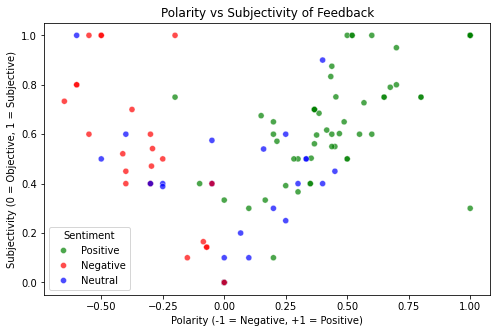

In [129]:
# plot subjectivity and polarity in a scatter plot
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,5))
sns.scatterplot(
    data=df, 
    x='blob_polarity', 
    y='blob_subjectivity', 
    hue='sentiment',       # color by sentiment
    palette={'Positive':'green', 'Neutral':'blue', 'Negative':'red'},
    alpha=0.7
)
plt.title('Polarity vs Subjectivity of Feedback')
plt.xlabel('Polarity (-1 = Negative, +1 = Positive)')
plt.ylabel('Subjectivity (0 = Objective, 1 = Subjective)')
plt.legend(title='Sentiment')
plt.show()
